# Hierarchical Forecasting

In this notebook we port the Pyro hierarchical multivariate forecasting example from the [Forecasting III: hierarchical models](https://pyro.ai/examples/forecasting_iii.html) tutorial to NumPyro.

We use the [BART train ridership dataset](https://www.bart.gov/about/reports/ridership), which contains the number of trips between all stations in the BART system by hour. The idea is to predict the number of trips for each station pair in the future. We do not want to do this separately for each station pair, but rather use the station-to-station structure and other features (seasonality) to generate forecasts.

This model port was originally presented in the blog post [From Pyro to NumPyro: Forecasting Hierarchical Models - Part II](https://juanitorduz.github.io/numpyro_hierarchical_forecasting_2/).

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import Array, random
import jax.numpy as jnp
import optax

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import load_bart_od
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.reparam import LocScaleReparam

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

assert numpyro.__version__.startswith("0.20.0")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz matplotlib optax

## Read Data

Let's load the data.

In [3]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
(78888, 50, 50)
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


Recall that our objective is to model all the rides from all stations to all other stations. For a simpler forecasting task, you can take a look into the introductory example

In [4]:
data = jnp.log1p(np.permute_dims(dataset["counts"], (1, 2, 0)))
T = data.shape[-2]
print(data.shape)

(50, 50, 78888)


## Train - Test Split

Similarly as in the Pyro example, we do a train test split. 

In [5]:
T2 = data.shape[-1]  # end
T1 = T2 - 24 * 7 * 2  # train/test split
T0 = T1 - 24 * 90  # beginning: train on 90 days of data

In [6]:
y = data[..., T0:T2]
y_train = data[..., T0:T1]
y_test = data[..., T1:T2]

print(f"y: {y.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

y: (50, 50, 2496)
y_train: (50, 50, 2160)
y_test: (50, 50, 336)


In [7]:
n_stations = y_train.shape[-2]

time = jnp.array(range(T0, T2))
time_train = jnp.array(range(T0, T1))
t_max_train = time_train.size

time_test = jnp.array(range(T1, T2))
t_max_test = time_test.size

covariates = jnp.zeros_like(y)
covariates_train = jnp.zeros_like(y_train)
covariates_test = jnp.zeros_like(y_test)

assert time_train.size + time_test.size == time.size
assert y_train.shape == (n_stations, n_stations, t_max_train)
assert y_test.shape == (n_stations, n_stations, t_max_test)
assert covariates.shape == y.shape
assert covariates_train.shape == y_train.shape
assert covariates_test.shape == y_test.shape

## Repeating Seasonal Features

In order to model the weekly seasonality, Pyro provides a very handy helper function [`periodic_repeat`](https://docs.pyro.ai/en/stable/ops.html#pyro.ops.tensor_utils.periodic_repeat) to repeat the seasonal features. Here we provide a JAX version of the function.


In [8]:
def periodic_repeat_jax(tensor: Array, size: int, dim: int) -> Array:
    """
    Repeat a period-sized tensor up to given size using JAX.

    Parameters
    ----------
    tensor : Array
        A JAX array to be repeated.
    size : int
        Desired size of the result along dimension `dim`.
    dim : int
        The tensor dimension along which to repeat.

    Returns
    -------
    Array
        The repeated tensor.

    References
    ----------
    https://docs.pyro.ai/en/stable/ops.html#pyro.ops.tensor_utils.periodic_repeat
    """
    assert isinstance(size, int) and size >= 0
    assert isinstance(dim, int)
    if dim >= 0:
        dim -= tensor.ndim

    period = tensor.shape[dim]
    repeats = [1] * tensor.ndim
    repeats[dim] = (size + period - 1) // period
    result = jnp.tile(tensor, repeats)

    slices = [slice(None)] * tensor.ndim
    slices[dim] = slice(None, size)

    return result[tuple(slices)]

## Model Specification

Here are the main components of the forecasting model:

- The local level dynamic is driven by the destination station. we use a hierarchical structure to model all the destination-level drift of the local level component. As these hierarchical models can have weird geometries to sample from, we also learn the re-parameterization parameters from the data.
- The seasonal components and the noise scales come as a sum of the origin and destination stations.

To make everything more tangible, let's look into the model structure in code.

In [9]:
def model(covariates: Array, y: Array | None = None) -> None:
    # Get the time and feature dimensions
    n_series, n_series, t_max = covariates.shape

    # Define the plates to be able to use them below
    origin_plate = numpyro.plate("origin", n_series, dim=-3)
    destin_plate = numpyro.plate("destin", n_series, dim=-2)
    hour_of_week_plate = numpyro.plate("hour_of_week", 24 * 7, dim=-1)

    # Global scale for the drift
    drift_scale = numpyro.sample("drift_scale", dist.LogNormal(loc=-20, scale=5))

    # Sample the centered parameter for the LocScaleReparam
    destin_centered = numpyro.sample("destin_centered", dist.Uniform(low=0, high=1))

    with origin_plate, hour_of_week_plate:
        origin_seasonal = numpyro.sample("origin_seasonal", dist.Normal(loc=0, scale=5))

    with destin_plate:
        with (
            numpyro.plate("time", t_max),
            numpyro.handlers.reparam(
                config={"drift": LocScaleReparam(centered=destin_centered)}
            ),
        ):
            # Sample the drift parameters
            # We have one drift parameter per time series (station) and time point
            drift = numpyro.sample("drift", dist.Normal(loc=0, scale=drift_scale))

        with hour_of_week_plate:
            # Sample the seasonal parameters
            # We have one seasonal parameter per hour of the week and per station
            destin_seasonal = numpyro.sample(
                "destin_seasonal", dist.Normal(loc=0, scale=5)
            )

    # We model a static pairwise station->station affinity, which e.g.
    # can compensate for the fact that people tend not to travel from
    # a station to itself.
    with origin_plate, destin_plate:
        pairwise = numpyro.sample("pairwise", dist.Normal(0, 1))

    # We model the origin and destination scales separately
    # and then add them together to get the final scale.
    with origin_plate:
        origin_scale = numpyro.sample("origin_scale", dist.LogNormal(-5, 5))
    with destin_plate:
        destin_scale = numpyro.sample("destin_scale", dist.LogNormal(-5, 5))
        scale = origin_scale + destin_scale

    # Repeat the seasonal parameters to match the length of the time series
    seasonal = origin_seasonal + destin_seasonal
    seasonal_repeat = periodic_repeat_jax(seasonal, t_max, dim=-1)

    # Define the local level transition function
    def transition_fn(carry, t):
        "Local level transition function"
        previous_level = carry
        current_level = previous_level + drift[..., t]
        return current_level, current_level

    # Compute the latent levels using scan
    _, pred_levels = jax.lax.scan(
        transition_fn, init=jnp.zeros((n_series,)), xs=jnp.arange(t_max)
    )

    # We need to transpose the prediction levels to match the shape of the data
    pred_levels = pred_levels.transpose(1, 0)

    # Compute the mean of the model
    mu = pred_levels + seasonal_repeat + pairwise

    # Sample the observations
    with numpyro.handlers.condition(data={"obs": y}):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=scale))

Let's visualize the model structure.

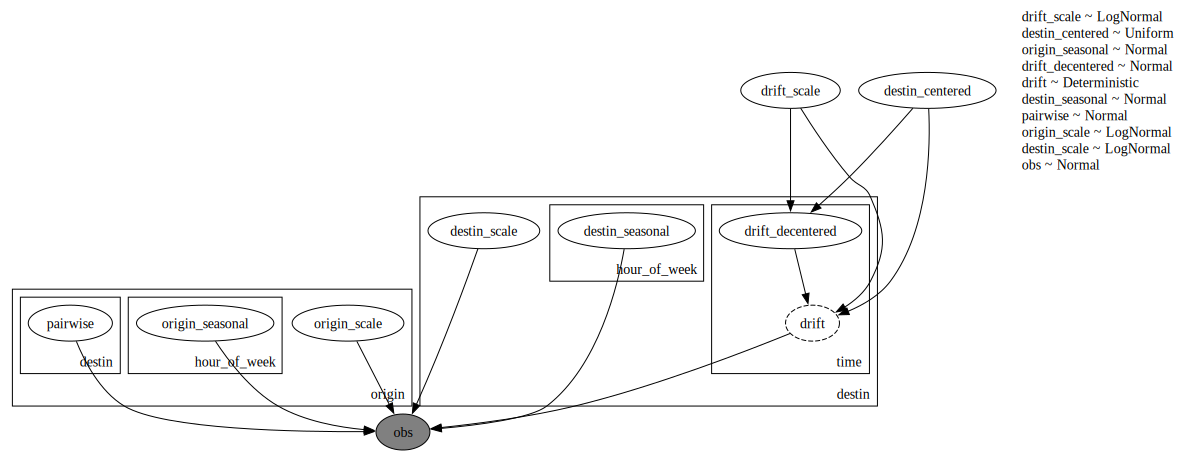

In [10]:
numpyro.render_model(
    model=model,
    model_kwargs={"covariates": covariates_train, "y": y_train},
    render_distributions=True,
    render_params=True,
)

## Prior Predictive Checks

As usual (highly recommended!), we should perform prior predictive checks.

In [11]:
prior_predictive = Predictive(model=model, num_samples=500, return_sites=["obs"])

rng_key, rng_subkey = random.split(rng_key)

prior_samples = prior_predictive(rng_subkey, covariates_train)

idata_prior = az.from_dict(
    prior_predictive={k: v[None, ...] for k, v in prior_samples.items()},
    coords={
        "time_train": time_train,
        "origin": dataset["stations"],
        "destin": dataset["stations"],
    },
    dims={"obs": ["origin", "destin", "time_train"]},
)

Let's plot the prior predictive distribution for the first $8$ stations for the destination station `ANTC`.

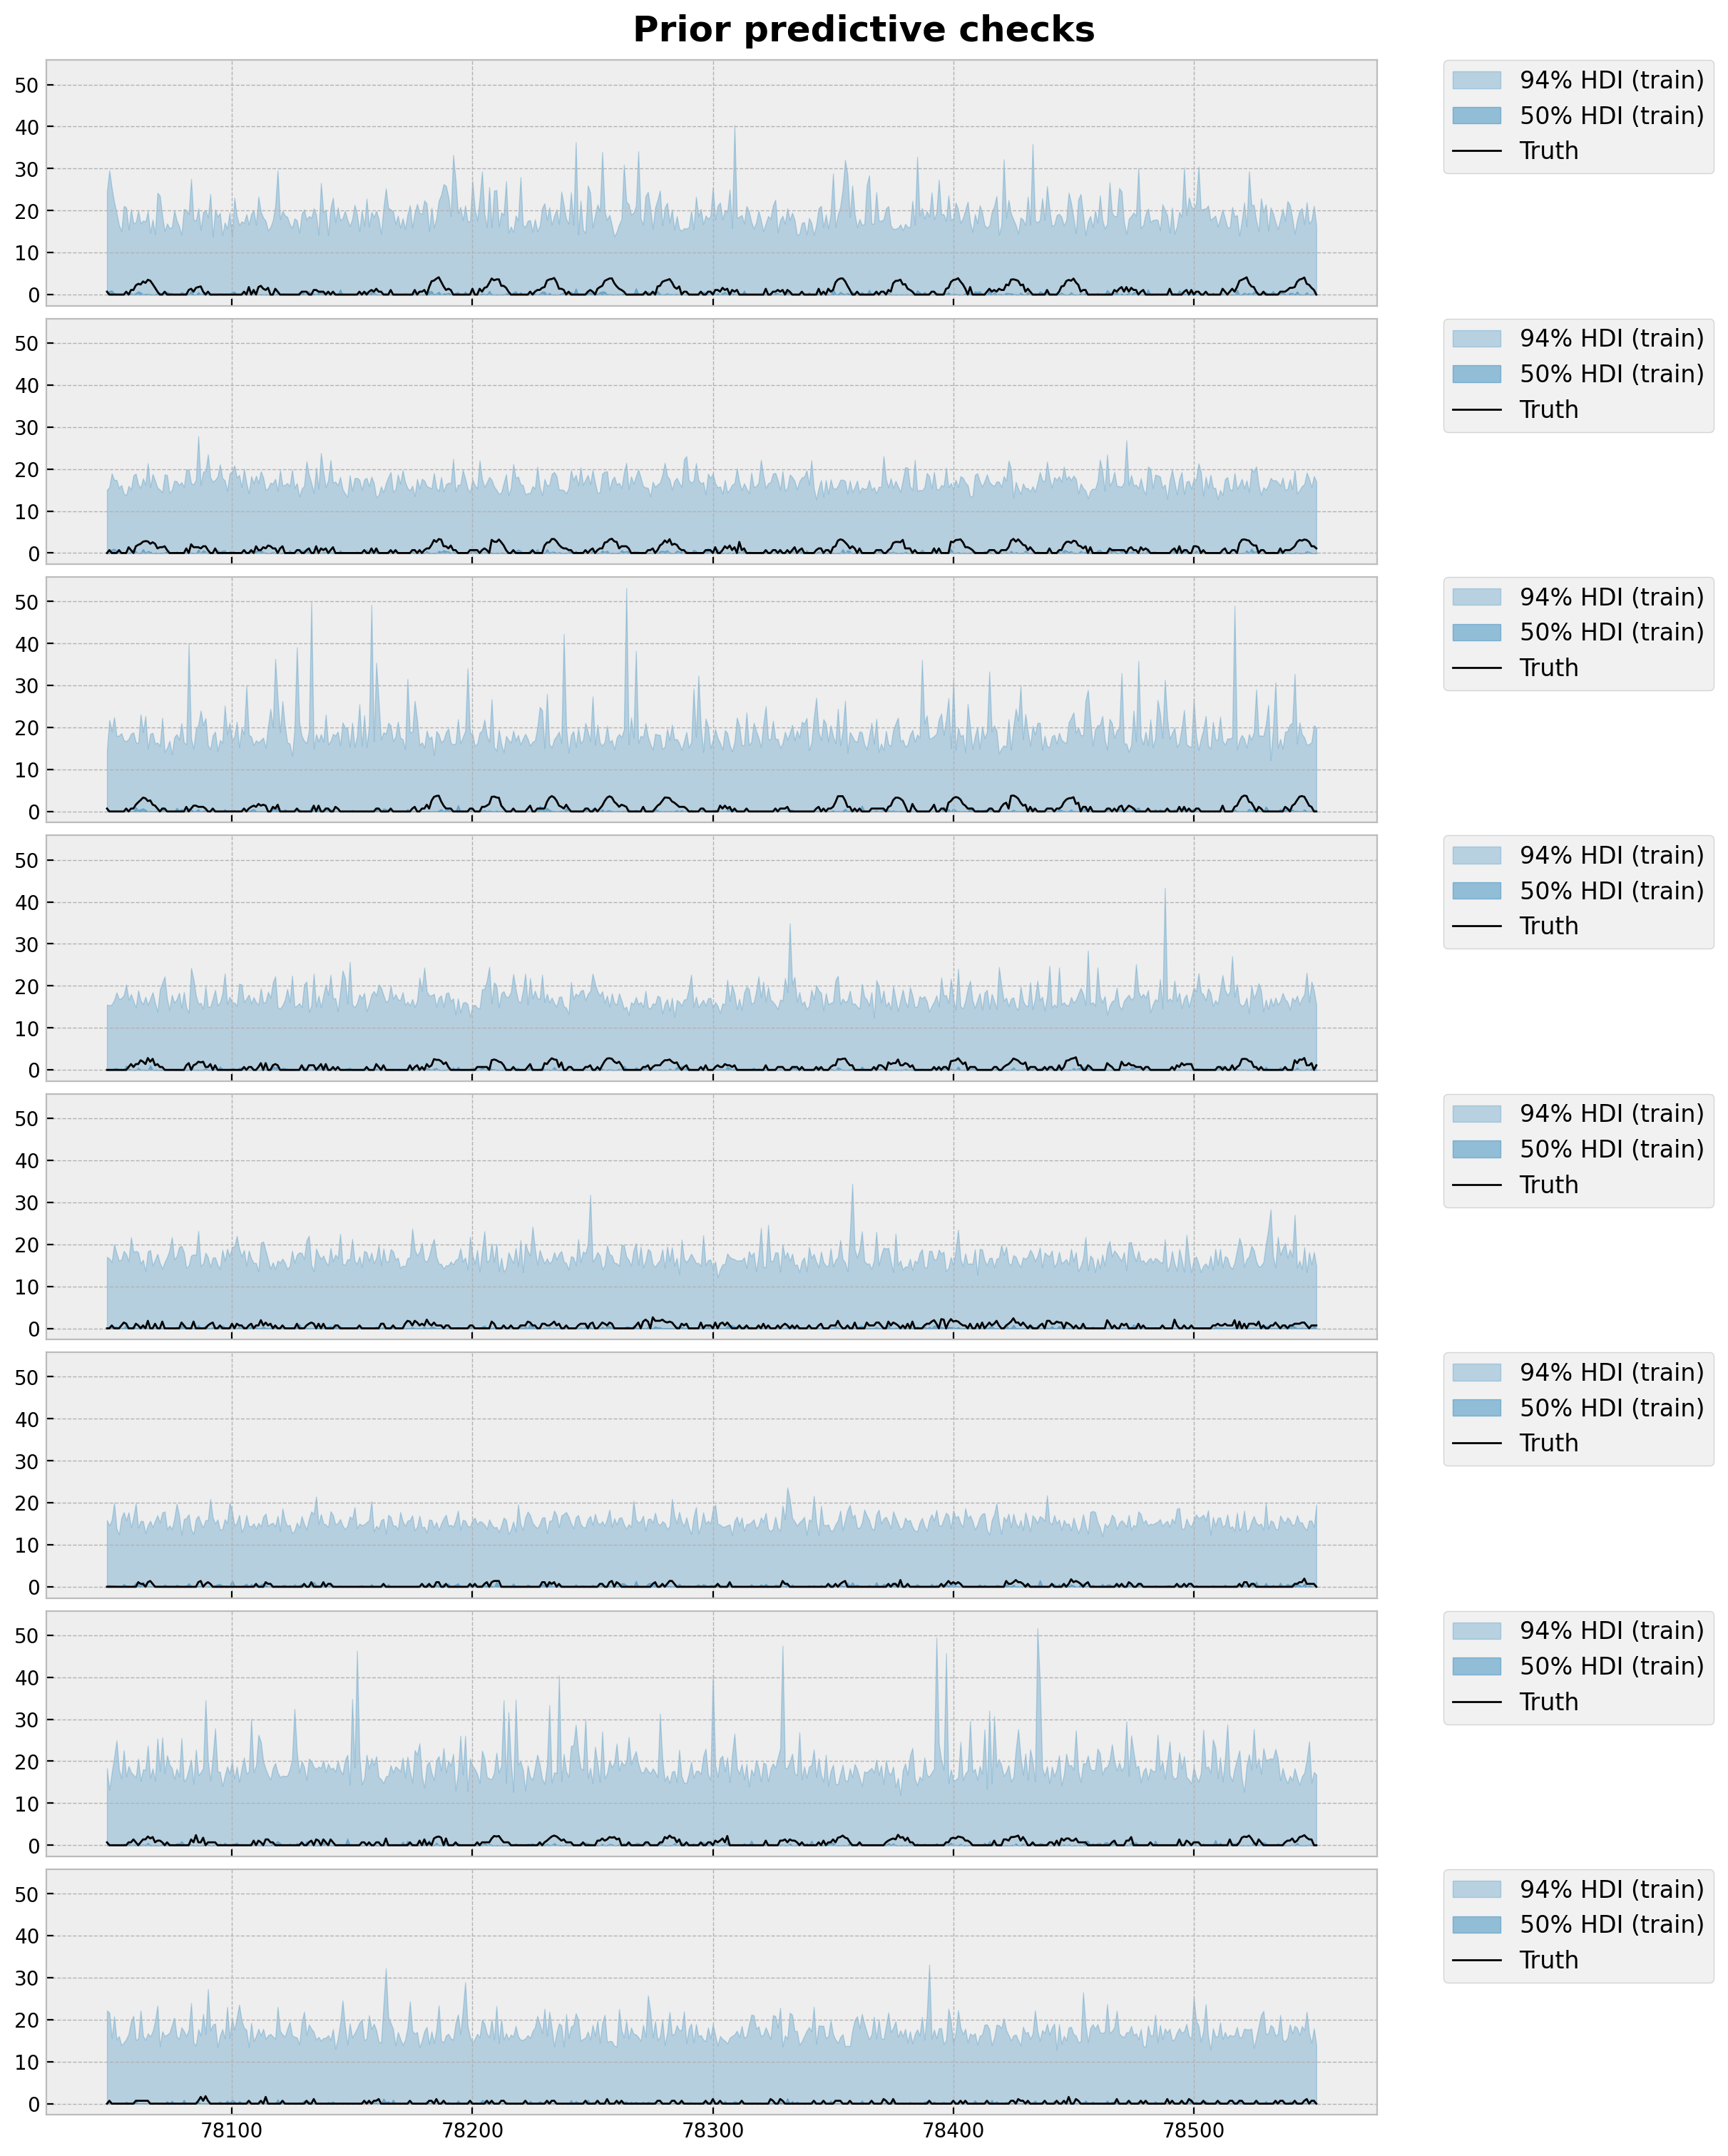

In [12]:
station = "ANTC"
idx = np.nonzero(dataset["stations"] == station)[0].item()

fig, axes = plt.subplots(
    nrows=8, ncols=1, figsize=(12, 15), sharex=True, sharey=True, layout="constrained"
)
for i, ax in enumerate(axes):
    for j, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            time_train[time_train >= T1 - 3 * (24 * 7)],
            idata_prior["prior_predictive"]["obs"]
            .sel(destin=station)
            .isel(origin=i)[:, :, np.array(time_train) >= T1 - 3 * (24 * 7)]
            .clip(min=0),
            hdi_prob=hdi_prob,
            color="C0",
            fill_kwargs={
                "alpha": 0.3 + 0.2 * j,
                "label": f"{hdi_prob * 100:.0f}% HDI (train)",
            },
            smooth=False,
            ax=ax,
        )

    ax.plot(
        time_train[time_train >= T1 - 3 * (24 * 7)],
        data[i, idx, T1 - 3 * (24 * 7) : T1],
        "black",
        lw=1,
        label="Truth",
    )

    ax.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=12
    )

fig.suptitle("Prior predictive checks", fontsize=18, fontweight="bold");

Overall, the prior ranges look very reasonable.


## Inference with SVI

We now fit the model to the data using stochastic variational inference. 

100%|██████████| 8000/8000 [02:54<00:00, 45.80it/s, init loss: 8788430848.0000, avg. loss [7601-8000]: 3667545.0000]


CPU times: user 8min 51s, sys: 1min 17s, total: 10min 8s
Wall time: 3min 2s


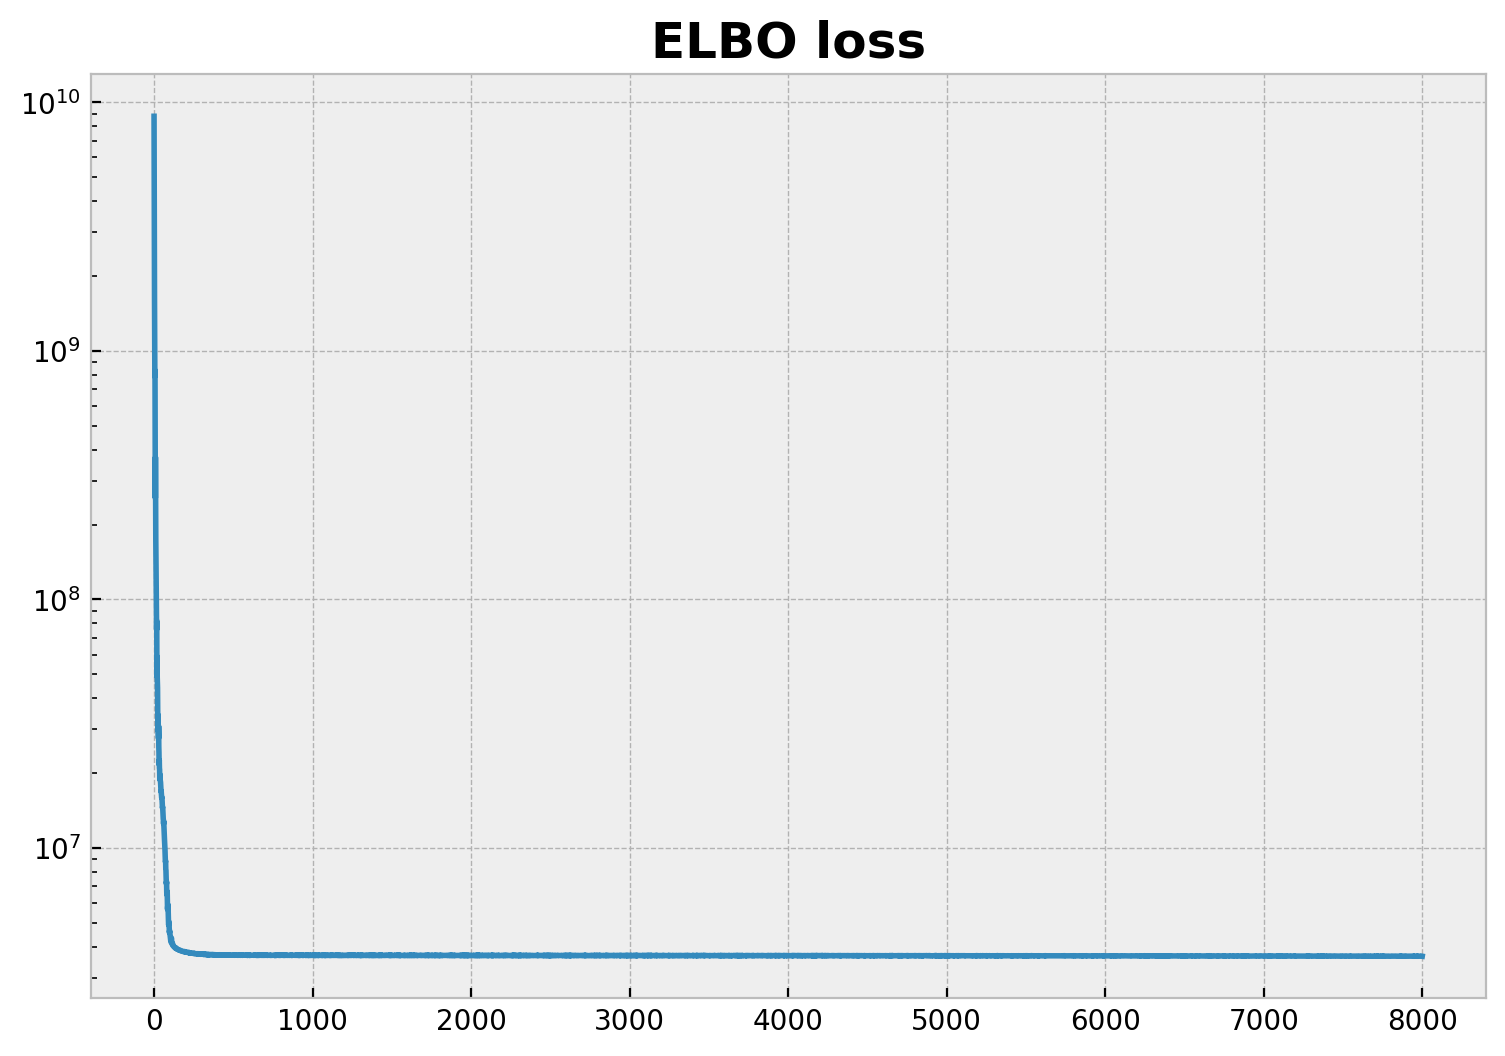

In [13]:
%%time

# See https://optax.readthedocs.io/en/latest/getting_started.html#custom-optimizers
scheduler = optax.linear_onecycle_schedule(
    transition_steps=8_000,
    peak_value=0.1,
    pct_start=0.1,
    pct_final=0.7,
    div_factor=2,
    final_div_factor=4,
)

optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.scale_by_adam(),
    optax.scale_by_schedule(scheduler),
    optax.scale(-1.0),
)


guide = AutoNormal(model)
optimizer = optimizer
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
num_steps = 8_000

rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(rng_subkey, num_steps, covariates_train, y_train)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_yscale("log")
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

The resulting ELBO loss good!

## Posterior Predictive Check

Next, we generate posterior predictive samples for the forecast for each of the stations pairs.

In [14]:
posterior = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=200,
    return_sites=["obs"],
)

In [15]:
rng_key, rng_subkey = random.split(rng_key)

idata_train = az.from_dict(
    posterior_predictive={
        k: v[None, ...] for k, v in posterior(rng_subkey, covariates_train).items()
    },
    coords={
        "time_train": time_train,
        "origin": dataset["stations"],
        "destin": dataset["stations"],
    },
    dims={"obs": ["origin", "destin", "time_train"]},
)

idata_test = az.from_dict(
    posterior_predictive={
        k: v[None, ...] for k, v in posterior(rng_subkey, covariates).items()
    },
    coords={
        "time": time,
        "origin": dataset["stations"],
        "destin": dataset["stations"],
    },
    dims={"obs": ["origin", "destin", "time"]},
)

## Model Evaluation

To evaluate the model performance,we compute the CRPS for the training and test data. We also port the Pyro code to compute the (empirical) CRPS (see [here](https://docs.pyro.ai/en/stable/_modules/pyro/ops/stats.html)) to JAX.

For comparison purposes, we clip the data to ensure the predictions are non-negative.

In [16]:
def crps(truth: Array, pred: Array) -> float:
    """Compute the CRPS for a given truth and prediction.

    Parameters
    ----------
    truth : Array
        The truth values.
    pred : Array
        A set of sample predictions batched on rightmost dim.
        This should have shape ``(num_samples,) + truth.shape``

    Returns
    -------
    crps : float
        The average CRPS score.

    References
    ----------
    https://docs.pyro.ai/en/stable/_modules/pyro/ops/stats.html
    """
    if pred.shape[1:] != (1,) * (pred.ndim - truth.ndim - 1) + truth.shape:
        raise ValueError(
            f"""Expected pred to have one extra sample dim on left.
            Actual shapes: {pred.shape} versus {truth.shape}"""
        )

    absolute_error = jnp.mean(jnp.abs(pred - truth), axis=0)

    num_samples = pred.shape[0]
    if num_samples == 1:
        return jnp.average(absolute_error)

    pred = jnp.sort(pred, axis=0)
    diff = pred[1:] - pred[:-1]
    weight = jnp.arange(1, num_samples) * jnp.arange(num_samples - 1, 0, -1)
    weight = weight.reshape(weight.shape + (1,) * (diff.ndim - 1))

    per_obs_crps = absolute_error - jnp.sum(diff * weight, axis=0) / num_samples**2
    return jnp.average(per_obs_crps)


crps_train = crps(
    y_train,
    jnp.array(idata_train["posterior_predictive"]["obs"].sel(chain=0).clip(min=0)),
)

crps_test = crps(
    y_test,
    jnp.array(
        idata_test["posterior_predictive"]["obs"]
        .sel(chain=0)
        .sel(time=slice(T1, T2))
        .clip(min=0)
    ),
)

Finally, we reproduce the model fit and plot from the Pyro example.

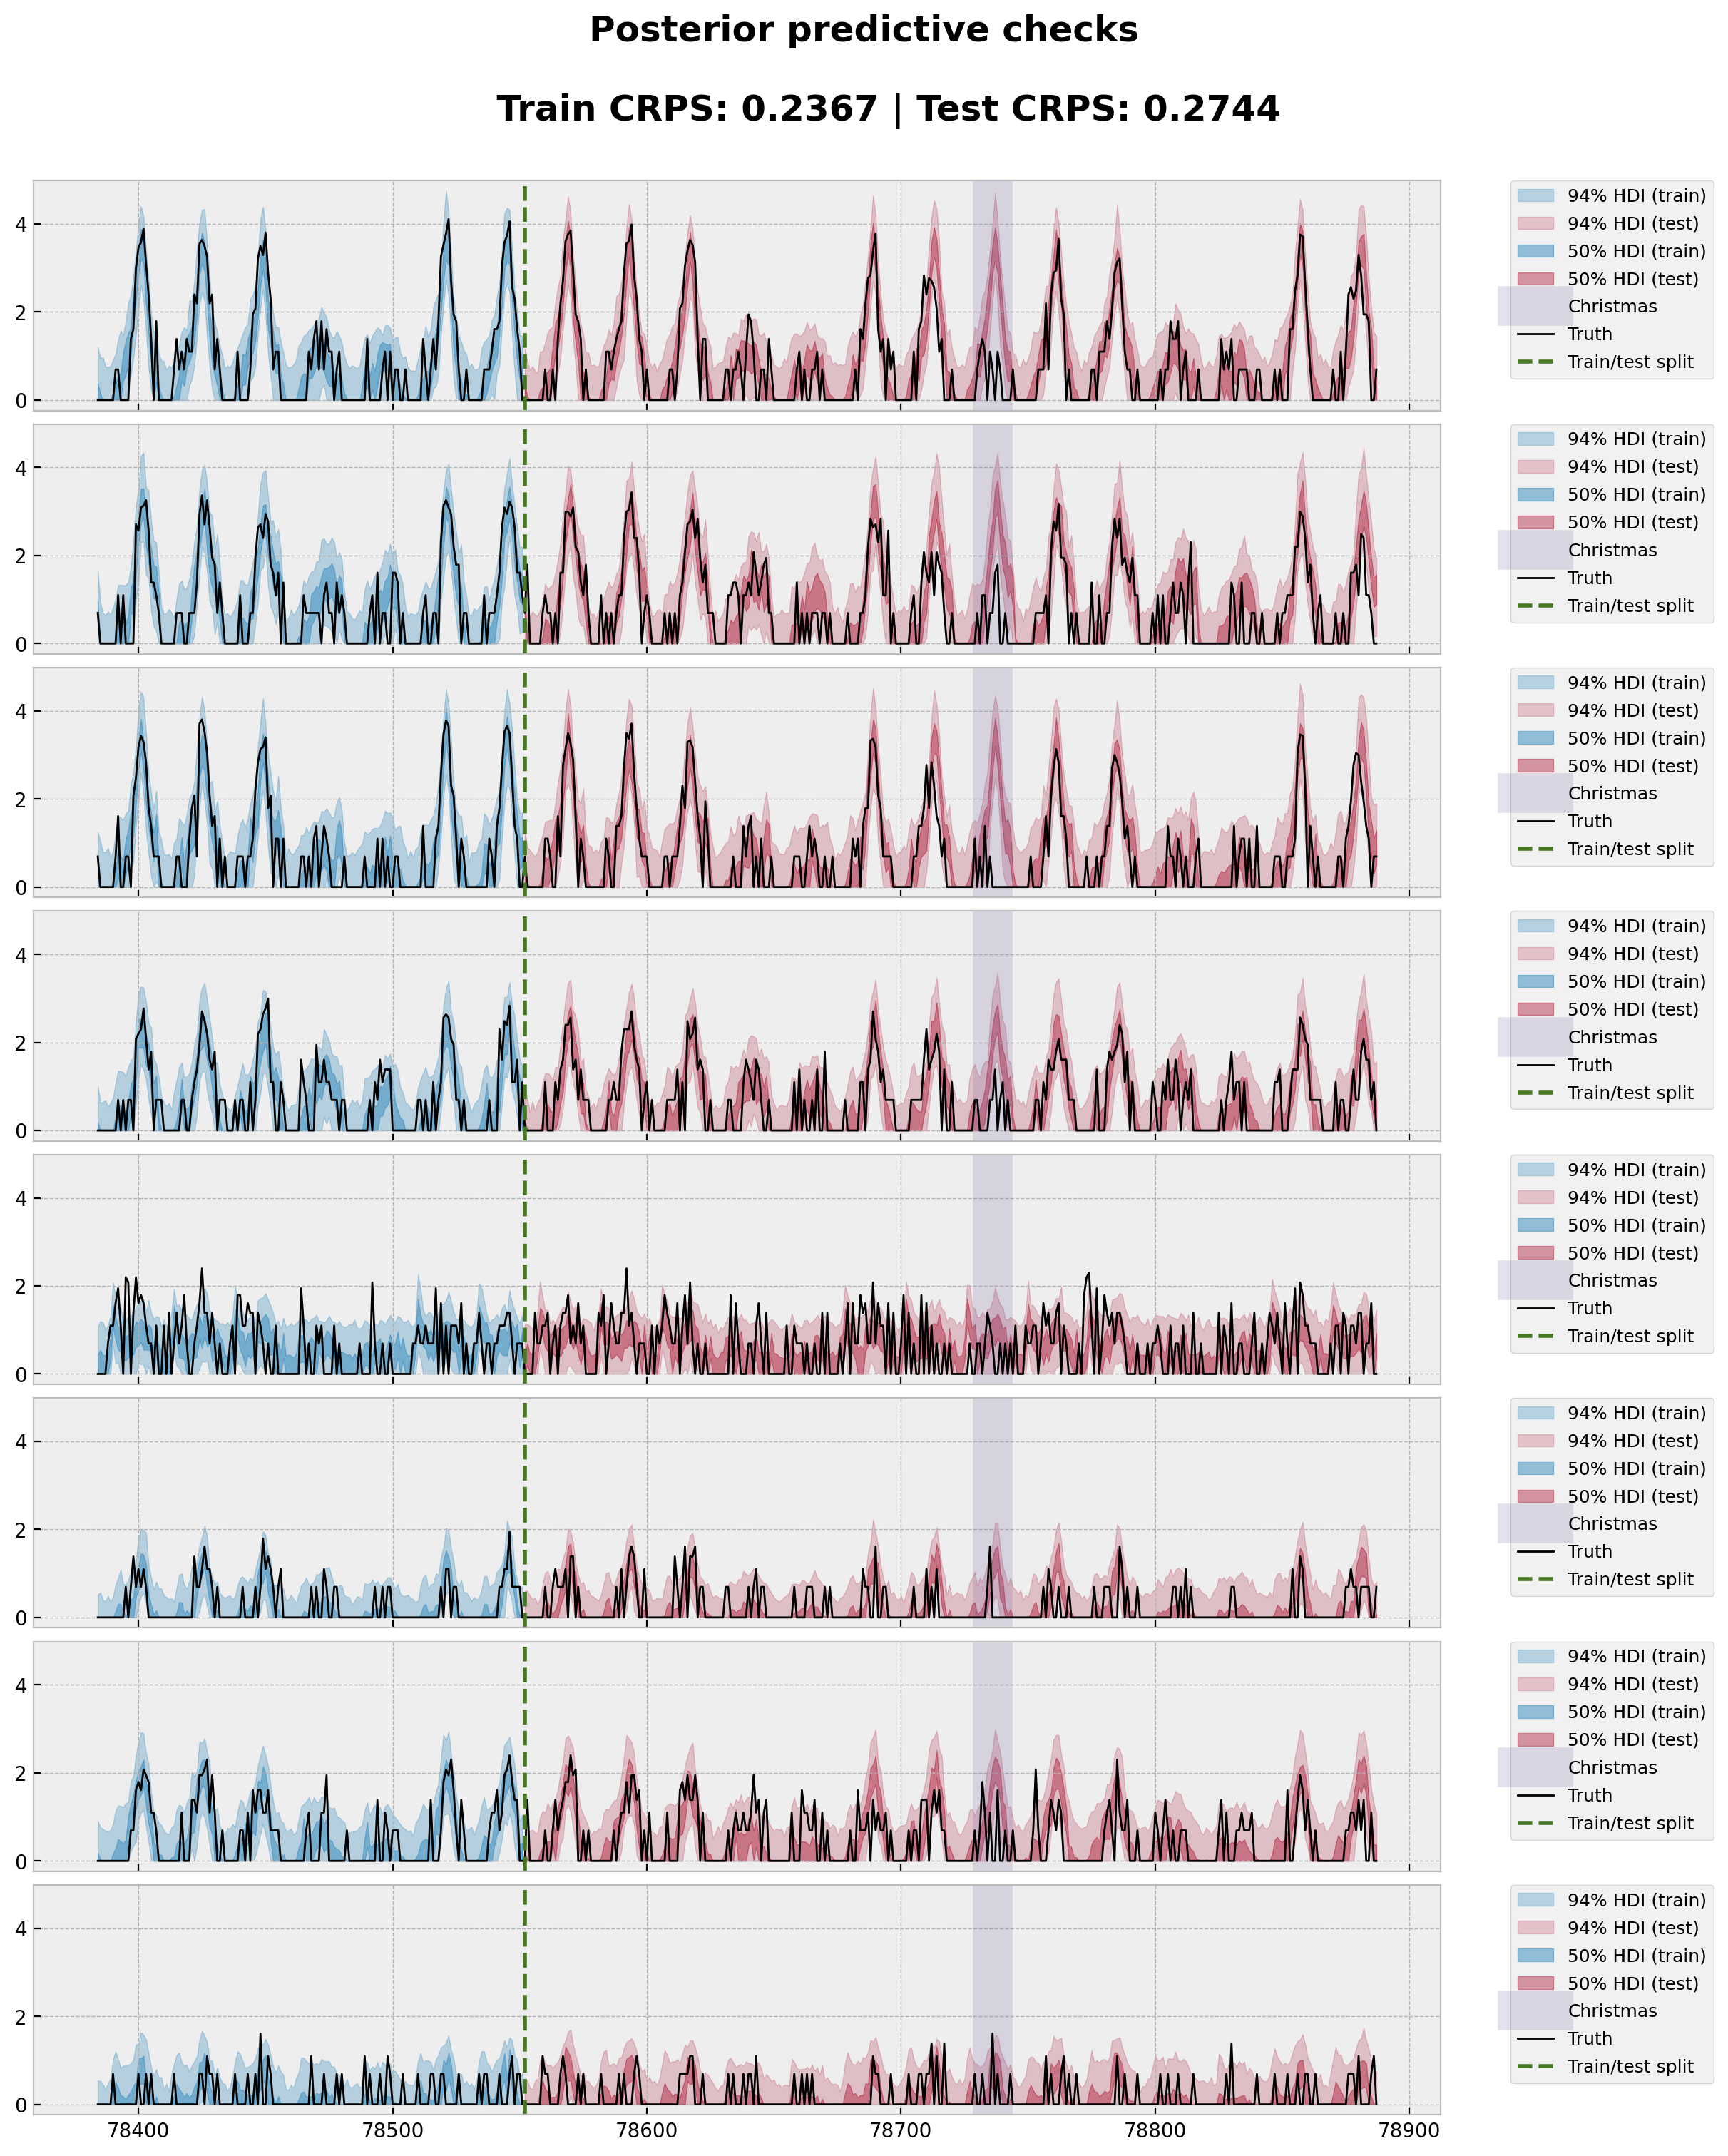

In [17]:
station = "ANTC"
idx = np.nonzero(dataset["stations"] == station)[0].item()

fig, axes = plt.subplots(
    nrows=8, ncols=1, figsize=(12, 15), sharex=True, sharey=True, layout="constrained"
)
for i, ax in enumerate(axes):
    for j, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            time_train[time_train >= T1 - 24 * 7],
            idata_train["posterior_predictive"]["obs"]
            .sel(destin=station)
            .isel(origin=i)[:, :, np.array(time_train) >= T1 - 24 * 7]
            .clip(min=0),
            hdi_prob=hdi_prob,
            color="C0",
            fill_kwargs={
                "alpha": 0.3 + 0.2 * j,
                "label": f"{hdi_prob * 100:.0f}% HDI (train)",
            },
            smooth=False,
            ax=ax,
        )

        az.plot_hdi(
            time[time >= T1],
            idata_test["posterior_predictive"]["obs"]
            .sel(destin=station)
            .isel(origin=i)[:, :, np.array(time) >= T1]
            .clip(min=0),
            hdi_prob=hdi_prob,
            color="C1",
            fill_kwargs={
                "alpha": 0.2 + 0.2 * j,
                "label": f"{hdi_prob * 100:.0f}% HDI (test)",
            },
            smooth=False,
            ax=ax,
        )

    christmas_index = 78736
    ax.axvline(christmas_index, color="C2", lw=20, alpha=0.2, label="Christmas")

    ax.plot(
        time[time >= T1 - 24 * 7],
        data[i, idx, T1 - 24 * 7 : T2],
        "black",
        lw=1,
        label="Truth",
    )

    ax.axvline(T1, color="C3", linestyle="--", label="Train/test split")

    ax.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0.0,
        fontsize=9,
        labelspacing=0.6,
    )

fig.suptitle(
    f"""Posterior predictive checks

    Train CRPS: {crps_train:.4f} | Test CRPS: {crps_test:.4f}
    """,
    fontsize=18,
    fontweight="bold",
);

Overall, the predictions seem quite good!